# Install dependencies

In [1]:
!pip install googletrans

     |████████████████████████████████| 61kB 3.2MB/s 
     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 983kB 6.4MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 71kB 6.7MB/s 
     |████████████████████████████████| 102kB 7.1MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp36-none-any.whl size=15736 sha256=41d6607e625fb84483fb92ce5870ff80dce825ee8cdee5d005a6f66ac2b4f9a6
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=bac0c5e9bd7288c7b7f764befbcfe3747b54567305e833c1eaceb02301a456d8
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


In [2]:
!pip install jieba

In [3]:
!pip install snownlp

     |████████████████████████████████| 37.6MB 1.2MB/s 
  Created wheel for snownlp: filename=snownlp-0.12.3-cp36-none-any.whl size=37760959 sha256=a9e56804b51b20b5955ed305562310e2cffd780244fcb895b08cbbef094e126c
  Stored in directory: /root/.cache/pip/wheels/f3/81/25/7c197493bd7daf177016f1a951c5c3a53b1c7e9339fd11ec8f
Successfully built snownlp


In [4]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 39kB/s 
     |████████████████████████████████| 204kB 50.5MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=ff2703910c5d2146d9e5eb2fe81cfb913b4ef6e0f9485fbd4a600fe77ed82946
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [30]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.types import Row
# NLP Module
from snownlp import SnowNLP
import jieba
# translation
from googletrans import Translator
import matplotlib.pyplot as plt
import pandas as pd

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [6]:
import urllib.request

In [11]:
file_url = "https://github.com/sirily11/hot-keywords/releases/download/master/Sina_keyword.csv"
file_name = "Sina_keyword.csv"
urllib.request.urlretrieve(file_url, file_name)

('Sina_keyword.csv', <http.client.HTTPMessage at 0x7f58c7be1b38>)

# Read csv file

In [12]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType

schema = StructType([
                     StructField('keyword', StringType(), False),
                     StructField("content", StringType(), False),
                     StructField("time", TimestampType(), False),
                     StructField("rank", IntegerType(), False),
                     StructField("numbers", IntegerType(), False),
])

In [13]:
df = spark.read.csv(file_name, schema=schema, lineSep=";")
df.show()

KeyboardInterrupt: ignored

In [10]:
rdd = df.rdd

In [11]:
rdd.take(10)

[Row(keyword='上海新增2例本地确诊病例', content='#澳亚【资讯】# #上海疫情# #上海新增2例本地确诊病例 追踪密接者83人#市卫健委今早（21日）通报：11月20日0—24时，通过口岸联防联控机制，报告9例境外输入性新冠肺炎确诊病例。新增治愈出院8例，其中来自阿联酋1例，来自俄罗斯1例，来自加拿大1例，来自马里1例，来自美国1例，来自塞尔维亚1例，来自乌克兰1例，来自乌兹别克斯坦1例。\n11月20日0—24时，新增2例本地新冠肺炎确诊病例。\n病例1、病例2为夫妻关系，常住浦东新区，因先后出现发热症状，前往医疗机构发热门诊就诊，即被隔离留观。11月20日，市、区疾控中心核酸检测结果为阳性。经专家会诊，综合临床、影像学表现和实验室核酸检测结果，诊断为确诊病例。\n目前，已追踪到其在本市的密切接触者83人，均已落实集中隔离观察。对病例曾活动过的场所已进行终末消毒。\n截至11月20日24时，累计报告境外输入性确诊病例956例，出院896例，在院治疗60例，无重症和危重症。现有待排查的疑似病例0例。\n截至11月20日24时，累计报告本地确诊病例345例，治愈出院335例，在院治疗3例，死亡7例。现有待排查的疑似病例0例。\n截至11月20日24时，尚在医学观察中的无症状感染者0例。 收起全文d', time=datetime.datetime(2020, 11, 21, 6, 5, 1, 673058), rank=49, numbers=108658),
 Row(keyword='上海新增2例本地确诊病例', content='【#上海新增2例本地确诊病例#，正全面开展流行病学调查】今天下午，上海浦东新区卫健委报告两例疑似新冠肺炎病例。病例1，男，39岁；病例2，女，34岁，两者系夫妻关系。因先后出现发热，到医院发热门诊就医，即被隔离排查。今晚21时，经上海市疾控中心新冠病毒核酸检测，结果均为阳性。经市级专家会诊，结合临床、影像学表现和实验室核酸检测结果，诊断为新冠肺炎确诊病例。\n目前，上海市、区相关部门已组成联合流调专家队伍，全面开展流行病学调查，正在追踪排查相关人员，对相关人员和环境采取相应的防疫措施。后续排查情况和相关人员的检测结果，将第一时间向社会发布。（总台央视记者陆学贤） 收起全文d', time=datetime.da

In [12]:
from time import sleep

# Translation

In [52]:
data = pd.read_csv("Sina_keyword.csv", error_bad_lines=False, names=['Keyword', 'Content', 'Time', 'Rank', 'Number'])
data = data[:100]

In [53]:
from time import sleep
from tqdm.auto import tqdm


tqdm.pandas()
translator = Translator()


In [56]:

translator.translate("你好").text

'你好'

In [51]:
def translate(index: str, content: str):
    has_translated = False
    while not has_translated:
        try:
            return translator.translate(content)
        except Exception:
            sleep(1)
            continue


data['Content_Translation'] = data.progress_apply(lambda row: translate(row.name, row['Content']), axis=1)

KeyboardInterrupt: ignored

In [37]:
data.head(10)

,Keyword,Content,Time,Rank,Number,Content_Translation
0,嫦娥五号,#嫦娥五号要奔月啦# 【嫦娥五号探测器完成第一次轨道修正】记者从国家航天局获悉，北京时间11...,2020-11-25 04:05:07.419591+00,49.0,107064.0,#嫦娥五号要奔月啦# 【嫦娥五号探测器完成第一次轨道修正】记者从国家航天局获悉，北京时间11...
1,嫦娥五号,#嫦娥探月#【加油，嫦娥五号！加油，中国航天！】11月24日凌晨4时30分，#嫦娥五号探月任...,2020-11-25 04:05:07.419591+00,49.0,107064.0,#嫦娥探月#【加油，嫦娥五号！加油，中国航天！】11月24日凌晨4时30分，#嫦娥五号探月任...
2,嫦娥五号,#嫦娥五号# 第二次参加长五任务，又一次圆满成功！每次在发射成功的那一刻就非常坚定自己要在航...,2020-11-25 04:05:07.419591+00,49.0,107064.0,#嫦娥五号# 第二次参加长五任务，又一次圆满成功！每次在发射成功的那一刻就非常坚定自己要在航...
3,嫦娥五号,#嫦娥五号# 第二次参加长五任务，又一次圆满成功！每次在发射成功的那一刻就非常坚定自己要在航...,2020-11-25 04:05:07.419591+00,49.0,107064.0,#嫦娥五号# 第二次参加长五任务，又一次圆满成功！每次在发射成功的那一刻就非常坚定自己要在航...
4,嫦娥五号,很好的科普话题，涨知识。\n「嫦娥五号」搭乘「长征五号」火箭发射成功，执行我国首次月球采样返...,2020-11-25 04:05:07.419591+00,49.0,107064.0,很好的科普话题，涨知识。\n「嫦娥五号」搭乘「长征五号」火箭发射成功，执行我国首次月球采样返...
5,嫦娥五号,【嫦娥五号发射成功 湖南“神猴”电缆助力探月】11月24日凌晨4时30分，在中国海南文昌发射...,2020-11-25 04:05:07.419591+00,49.0,107064.0,【嫦娥五号发射成功 湖南“神猴”电缆助力探月】11月24日凌晨4时30分，在中国海南文昌发射...
6,嫦娥五号,【中国探月工程“三步走”的收官之战打响】11月24日凌晨，中国文昌航天发射场。长征五号遥五运...,2020-11-25 04:05:07.419591+00,49.0,107064.0,【中国探月工程“三步走”的收官之战打响】11月24日凌晨，中国文昌航天发射场。长征五号遥五运...
7,嫦娥五号,【嫦娥五号发射成功 湖南“神猴”电缆助力探月】11月24日凌晨4时30分，在中国海南文昌发射...,2020-11-25 04:05:07.419591+00,49.0,107064.0,【嫦娥五号发射成功 湖南“神猴”电缆助力探月】11月24日凌晨4时30分，在中国海南文昌发射...
8,嫦娥五号,欧洲航天局：很高兴为嫦娥五号探月提供数据传输支持O欧洲航天局：很高兴为嫦娥五号探月提供数据传输支持,2020-11-25 04:05:07.419591+00,49.0,107064.0,欧洲航天局：很高兴为嫦娥五号探月提供数据传输支持O欧洲航天局：很高兴为嫦娥五号探月提供数据传输支持
9,嫦娥五号,关于嫦娥登月，做科研，原来多年前老夫子漫画里也写了\n@Steed的围脖 #嫦娥五号#,2020-11-25 04:05:07.419591+00,49.0,107064.0,关于嫦娥登月，做科研，原来多年前老夫子漫画里也写了\n@Steed的围脖 #嫦娥五号#


## preprocess data

In [ ]:
def preprocess(row):
    d = row.asDict()
    if d['content']:
        d['content'] = d['content'].replace("展开全文c", "")
        d['content'] = d['content'].replace("收起全文d", "")
        d['content'] = d['content'].replace(f"{d['keyword']}", "")
        d['content'] = d['content'].replace("#", "")
        d['content'] = d['content'].replace("\n", "")
    new_row = Row(**d)
    return new_row

new_data = rdd.map(preprocess)
print(new_data.take(10))
new_data.cache()

[Row(keyword='aespa出道曲初舞台', content='我对aespa真香了', time=datetime.datetime(2020, 11, 19, 13, 4, 5, 14218), rank=41, numbers=206090), Row(keyword='天津大学一教授被实名举报学术造假', content='刚刚吃饭的时候看着天大老师造假的事，气愤的不行，然后就收到了我师妹的消息，笑的不行，分享一个我迷糊老师的日常，我们平常比做实验更重要的事就是带钥匙🔑，不然可能出去上个厕所，就进不去实验室了另外请大家不要因为各别老师，而对整个学术业失望，还是有很多老师，很多学生在为这个行 ', time=datetime.datetime(2020, 11, 20, 5, 4, 30, 310980), rank=9, numbers=1043499), Row(keyword='选秀中的心脏狙击名场面', content='\ue627任豪POI rh既然提到了豪豪，那就来看看吧！@R1SE-任豪', time=datetime.datetime(2020, 11, 20, 20, 4, 20, 475064), rank=47, numbers=21300), Row(keyword='电视剧半生缘改名情深缘起', content='不知道是广电有毛病还是怎样，动不动给人电视剧赐名改名，孤城闭，撒野，半生缘，掌中之物，人家名字多好听，改你🐴 哦，就知道瞎改，电视剧运气都给你改掉一半…', time=datetime.datetime(2020, 11, 20, 22, 5, 5, 155120), rank=16, numbers=67914), Row(keyword='跳化粪池救娃退役军人收到救助金', content='以后还会继续做好事、好样的！真的令人敬佩！', time=datetime.datetime(2020, 11, 21, 6, 5, 1, 624606), rank=10, numbers=714340), Row(keyword='武则天她妈在钦州研究工作组更名', content='白富美曹译文的新瓜投稿，波士顿大学gpa低于2.0被退学，在美国读研期间还被诈骗差点被绑架..骗子大概就是骗她：你爹在国内惹上了大麻烦

PythonRDD[33] at RDD at PythonRDD.scala:53

In [ ]:
jieba.initialize()
tokenizer = jieba.Tokenizer()

In [ ]:
def sentiment(row):
    try:
        s = SnowNLP(row.content)
        return (row.keyword, (s.sentiments, row.content))
    
    except Exception:
        return ("error", "nil")

def keyword(row):
    return jieba.lcut(row.keyword, cut_all=False), row



sentiments = new_data.map(sentiment).filter(lambda x: x[0] != "error" and x[1] != "nil")
sentiments.cache().take(10)

[('aespa出道曲初舞台', (0.6292287669391688, '我对aespa真香了')),
 ('天津大学一教授被实名举报学术造假',
  (0.9952895196778796,
   '刚刚吃饭的时候看着天大老师造假的事，气愤的不行，然后就收到了我师妹的消息，笑的不行，分享一个我迷糊老师的日常，我们平常比做实验更重要的事就是带钥匙🔑，不然可能出去上个厕所，就进不去实验室了另外请大家不要因为各别老师，而对整个学术业失望，还是有很多老师，很多学生在为这个行 ')),
 ('选秀中的心脏狙击名场面',
  (0.8225709747637443, '\ue627任豪POI rh既然提到了豪豪，那就来看看吧！@R1SE-任豪')),
 ('电视剧半生缘改名情深缘起',
  (0.6790462184223255,
   '不知道是广电有毛病还是怎样，动不动给人电视剧赐名改名，孤城闭，撒野，半生缘，掌中之物，人家名字多好听，改你🐴 哦，就知道瞎改，电视剧运气都给你改掉一半…')),
 ('跳化粪池救娃退役军人收到救助金', (0.824867218915397, '以后还会继续做好事、好样的！真的令人敬佩！')),
 ('武则天她妈在钦州研究工作组更名',
  (0.37617857183276393,
   '白富美曹译文的新瓜投稿，波士顿大学gpa低于2.0被退学，在美国读研期间还被诈骗差点被绑架..骗子大概就是骗她：你爹在国内惹上了大麻烦 叫她切断和家人的一切联系并且躲在酒店里…结果她不但信了 还拔了sim卡 乖乖照做 她爹当时着实被吓到 她爹还是有点人脉吧 动用了很多关系 几乎发动了相当大 ')),
 ('秋日栗栗排骨饭',
  (0.9999301000032879,
   '【板栗炖排骨】板栗软糯香甜，和排骨一起炖到软烂，酱油的咸味和板栗的甜味融合在一起，让人无法抗拒～微博厨房大赛 via：好好吃 L最爱学做饭的微博视频')),
 ('隐秘而伟大', (0.9961075258005379, '\ue627金晨严重剧透慎入，都是超级喜欢的片段电视剧')),
 ('单依纯好声音冠军', (0.9996645862980169, ' 呜呜呜呜不愧是我滴女神太棒啦！！！！！虽然是意料之中 但是还是忍不住非常激动')),
 ('丁放背叛顾耀东',
  

In [ ]:
def groupValues(values):
    total = 0
    i = 0
    for v in values:
        sentiments, content = v
        total += sentiments
        i += 1
    
    return total / i

grouped = sentiments.groupByKey().mapValues(groupValues)
print(grouped.take(10))

KeyboardInterrupt: ignored

In [ ]:
pos = sentiments.filter(lambda x: x[1][0] > 0.75).count()
neg = sentiments.filter(lambda x: x[1][0] <= 0.35).count()

In [ ]:
net = sentiments.filter(lambda x: x[1][0] > 0.35 and x[1][0] <= 0.75).count()

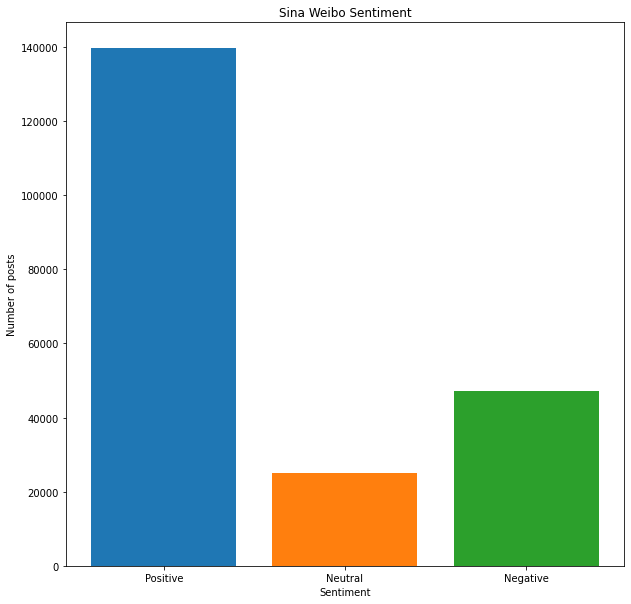

In [ ]:
plt.figure(figsize=(10,10))
plt.bar("Positive", pos)
plt.bar("Neutral", net)
plt.bar("Negative", neg)
plt.xlabel("Sentiment")
plt.ylabel("Number of posts")
plt.title("Sina Weibo Sentiment")
plt.savefig("sina.png")